# This notebook checks if the data lies in a non-linear manifold.

To do this, the following tests are proposed: 
1. Compare the residual variance of an non-linarmodel (Local PCA) to PCA. In a Non-linear manifil the PCA-model should need more components for explaining the same amout of variance. Source: Bachmann, C. M., et al. (2005). "Exploiting manifold structure in hyperspectral imagery." and Tenenbaum, J. B., et al. (2000). "A Global Geometric Framework for Nonlinear Dimensionality Reduction."

In [11]:
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
from hypso import Hypso
from utils import calculate_rmse, calculate_sam
import os
from sklearn.decomposition import PCA
from MFA import MFA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


data_dir = glob.glob('data/linearity_test/*.nc')
print(f"Found {len(data_dir)} files.")

Found 49 files.


### 1. Residual test
This test compares the residual of a global and a local PCA model.
-The global PCA model will be made from all the pixels. 
-The local PCA model will use K-means to cluster the data into distrinct groups, than individual models will train on those pixels. 

In [3]:
target_total_samples = 20000
samples_per_file = target_total_samples // len(data_dir) 
sampled_data_list = []

print(f"Aiming to extract ~{samples_per_file} pixels per file.")

for file in data_dir:
    # Load Data
    try:
        satobj = Hypso(file) 
        if satobj is None: continue
        
        # Load and reshape
        data = satobj.l1a_cube.values.astype(np.float32)
        h, w, b = data.shape
        data_2d = data.reshape(-1, b) # Shape: (Total_Pixels_In_Image, 120)
        
        # Random Subsampling 
        total_pixels_in_image = data_2d.shape[0]
        
        # Determine how many to take (don't take more than exists)
        n_to_take = min(samples_per_file, total_pixels_in_image)
        
        # Generate random indices
        rng = np.random.default_rng()
        indices = rng.choice(total_pixels_in_image, size=n_to_take, replace=False)
        
        # Grab the random pixels and add to list
        sampled_pixel_subset = data_2d[indices, :]
        sampled_data_list.append(sampled_pixel_subset)
        
        print(f"File: {os.path.basename(file)} | Extracted {n_to_take} pixels.")

    except Exception as e:
        print(f"Error processing {file}: {e}")

# Final Concatenation
if sampled_data_list:
    final_dataset = np.concatenate(sampled_data_list, axis=0)
    print("-" * 30)
    print(f"Final Analysis Dataset Shape: {final_dataset.shape}")
else:
    print("No data loaded.")

Aiming to extract ~408 pixels per file.
File: aeronetgalata_2025-01-02T08-18-16Z-l1a.nc | Extracted 408 pixels.
File: algeria_2022-10-29T09-44-03Z-l1a.nc | Extracted 408 pixels.
File: amazonia_2024-09-21T13-12-47Z-l1a.nc | Extracted 408 pixels.
File: annapolis_2025-08-04T15-25-40Z-l1a.nc | Extracted 408 pixels.
File: antarctica_2022-11-20T08-44-35Z-l1a.nc | Extracted 408 pixels.
File: barfire_2025-08-04T09-11-36Z-l1a.nc | Extracted 408 pixels.
File: bermuda_2024-07-16T14-27-21Z-l1a.nc | Extracted 408 pixels.
File: blacksea2_2024-07-21T07-40-44Z-l1a.nc | Extracted 408 pixels.
File: capedyer_2023-10-16T14-54-55Z-l1a.nc | Extracted 408 pixels.
File: capescott_2023-05-09T19-29-59Z-l1a.nc | Extracted 408 pixels.
File: caspiansea1_2024-08-22T07-05-53Z-l1a.nc | Extracted 408 pixels.
File: caspiansea3_2024-07-12T06-35-24Z-l1a.nc | Extracted 408 pixels.
File: el-tabitano_2022-12-15T14-19-33Z-l1a.nc | Extracted 408 pixels.
File: erie_2023-11-23T16-03-05Z-l1a.nc | Extracted 408 pixels.
File: erie

#### Making PCA-model 
1. Calcualte the mean and perform mean-centering
2. Make the PCA model
3. Calculate the residual error

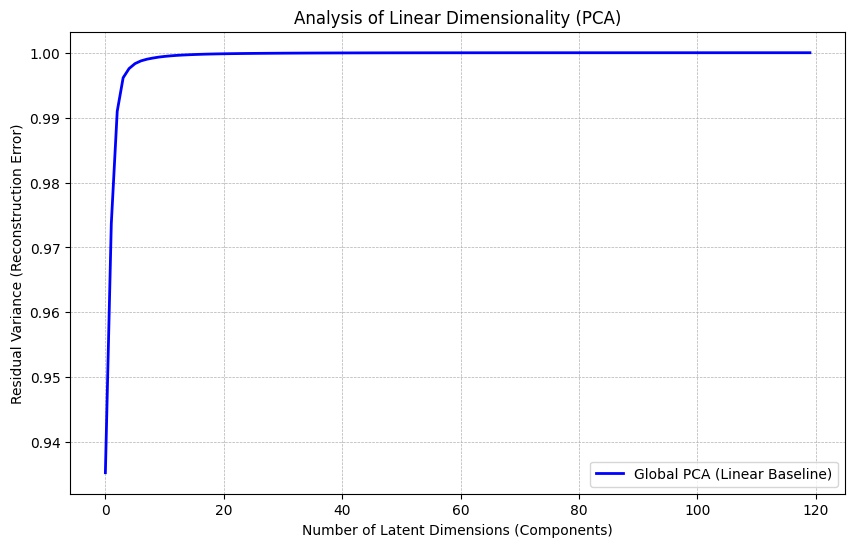

Variance explained by first 3 components: 0.9910
Components needed for 99% variance: 3


In [ ]:
# Calculate Mean
mean_spectrum = np.mean(final_dataset, axis=0)

# Make the PCA Model
pca = PCA() 

# Fit the model to your data
pca.fit(final_dataset)

# Calculate Cumulative Residual Error
explained_variance_ratios = pca.explained_variance_ratio_

# Cumulative Variance: The sum of variance explained as we add components.
cumulative_variance = np.cumsum(explained_variance_ratios)

plt.figure(figsize=(10, 6))

# Plot the PCA curve
plt.plot(range(len(cumulative_variance)), cumulative_variance, 
         label='Global PCA (Linear Baseline)', color='blue', linewidth=2)

plt.xlabel('Number of Latent Dimensions (Components)')
plt.ylabel('Explained Variance')
plt.title('Analysis of Linear Dimensionality (PCA)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

plt.show()

# Print key stats for your text
print(f"Variance explained by first 3 components: {cumulative_variance[2]:.4f}")
print(f"Components needed for 99% variance: {np.argmax(cumulative_variance >= 0.99) + 1}")

The PCA explains most of the variance in a few components. However, as Richards argues, the first component is allmost allways a weighted average of all the bands, thus the first component works as a global average of the lighting conditions, and this is a linear phenomenon that is well captured by a global model. \

Source: Richards, J. A., & Jia, X. (2006). Remote Sensing Digital Image Analysis: An Introduction (4th ed.). Springer.

Chang further examplifies this, and argues that the "Background" is low-rank (high variance, easily modeled by PCA), while the "Targets" are sparse and high-rank (low variance).

The Argument: He distinguishes between "Background Modeling" (the 99%) and "Target Detection" (the 1%). He argues that PCA is optimal for representation (compressing the background) but often suboptimal for detection because it suppresses the low-variance biological/chemical signatures as "noise. \

Source: Chang, C.-I. (2007). Hyperspectral Data Exploitation: Theory and Applications. Wiley-Interscience. (Or his 2005 paper: Hyperspectral Imaging: Techniques for Spectral Detection and Classification)

#### Model selection

Performing model-selection to choose the uptimal number of components. This is done by a forward selection using MSE as the metric. 



Manifold Test: Global vs. Local PCA (Based on Residual Error)
K     | MSE (Residual)       | BIC (approx)        
----------------------------------------------------------------------
1     | 38486802.860758      | 356316.92           
2     | 31242278.248254      | 359287.85           
3     | 24702004.575934      | 361732.10           
4     | 17217600.972452      | 361656.07           
5     | 15531199.503018      | 366735.39           
6     | 13852125.658405      | 371588.19           
7     | 11315395.486190      | 374684.44           
8     | 10612342.302749      | 380542.15           
9     | 10293195.265167      | 387071.83           
10    | 9113386.451182       | 391778.16           
----------------------------------------------------------------------


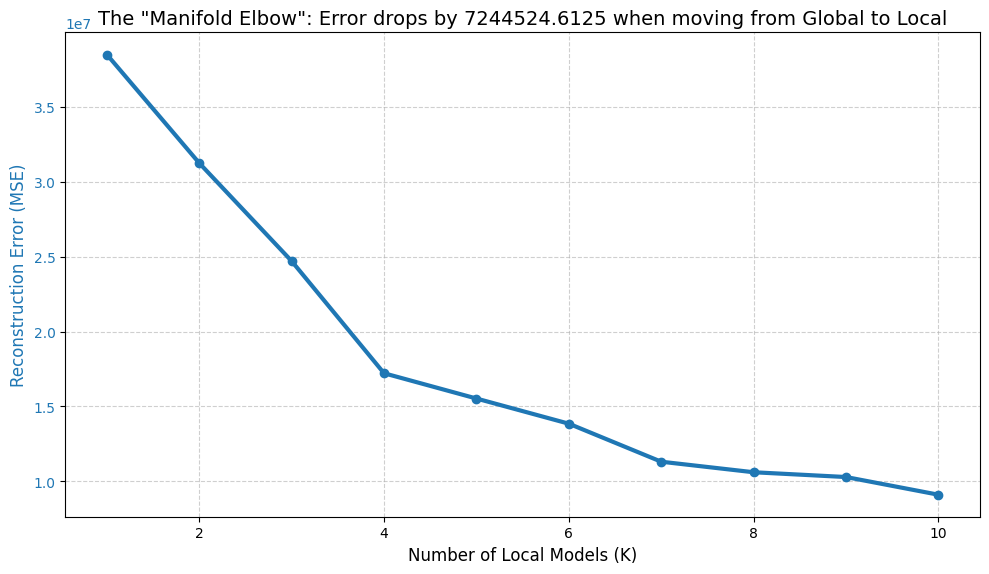

In [9]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# --- Setup ---
# X = final_dataset (Standardized or Normalized)
n_samples, n_features = X.shape
latent_q = 5   # Fixed number of components (e.g., 5)
k_range = range(1, 11) # Test Global (K=1) vs Local (K=2..10)

print(f"\n{'='*70}")
print(f"Manifold Test: Global vs. Local PCA (Based on Residual Error)")
print(f"{'='*70}")
print(f"{'K':<5} | {'MSE (Residual)':<20} | {'BIC (approx)':<20}")
print("-" * 70)

mse_scores = {}
for K in k_range:
    # 1. Cluster (Partition the Manifold)
    if K == 1:
        labels = np.zeros(n_samples) # Global Model
    else:
        kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
    
    total_squared_error = 0
    
    # 2. Fit Regular PCA for each cluster
    for i in range(K):
        cluster_data = X[labels == i]
        n_cluster_samples = cluster_data.shape[0]
        
        # Skip tiny clusters
        if n_cluster_samples <= latent_q:
            continue
            
        # Standard PCA
        pca = PCA(n_components=latent_q)
        pca.fit(cluster_data)
        
        # 3. Calculate Residuals (Reconstruction Error)
        # Transform to latent space -> Inverse transform back -> Calc Error
        X_projected = pca.inverse_transform(pca.transform(cluster_data))
        squared_error = np.sum((cluster_data - X_projected) ** 2)
        total_squared_error += squared_error

    # 4. Calculate Metrics
    mse = total_squared_error / n_samples
    mse_scores[K] = mse
    
    # Simple BIC Approximation for Least Squares: n * ln(MSE) + k * ln(n)
    # This penalizes us for adding more clusters (K)
    num_parameters = K * (n_features * latent_q + n_features + 1)
    bic = n_samples * np.log(mse) + num_parameters * np.log(n_samples)

    print(f"{K:<5} | {mse:<20.6f} | {bic:<20.2f}")

print("-" * 70)


fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot MSE (The Geometric Argument)
color = 'tab:blue'
ax1.set_xlabel('Number of Local Models (K)', fontsize=12)
ax1.set_ylabel('Reconstruction Error (MSE)', color=color, fontsize=12)
ax1.plot(list(mse_scores.keys()), list(mse_scores.values()), marker='o', color=color, linewidth=3, label='MSE (Residuals)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.6)

# Highlight the Drop
initial_drop = mse_scores[1] - mse_scores[2] if 2 in mse_scores else 0
plt.title(f'The "Manifold Elbow": Error drops by {initial_drop:.4f} when moving from Global to Local', fontsize=14)

plt.tight_layout()
plt.show()

Making the local model with K = 7 clusters

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

X = final_dataset  
n_components = 5
K = 4

print(f"Dataset Shape: {X.shape}")
print(f"Testing Manifold with q={n_components} dimensions and K={K} clusters.\n")

# For the MSE argument, clustering on Raw X is usually safer for the "first test"
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

global_pca = PCA(n_components=n_components)
X_global_transformed = global_pca.fit_transform(X)
X_global_reconstructed = global_pca.inverse_transform(X_global_transformed)

# Global MSE (Mean Squared Error per element)
global_mse = np.mean((X - X_global_reconstructed) ** 2)
print(f"Global PCA ({n_components} comps) MSE: {global_mse:.6f}")

local_sse_total = 0 # Sum of Squared Errors
total_elements = X.shape[0] * X.shape[1] # Total number of values (N * Bands)

print(f"\nTraining {K} Local PCA models...")

for k in range(K):
    cluster_indices = np.where(labels == k)[0]
    X_cluster = X[cluster_indices]
    
    if len(X_cluster) < n_components:
        continue
        
    local_pca = PCA(n_components=n_components)
    X_k_trans = local_pca.fit_transform(X_cluster)
    X_k_recon = local_pca.inverse_transform(X_k_trans)
    
    # Calculate Sum of Squared Errors for this cluster
    cluster_sse = np.sum((X_cluster - X_k_recon) ** 2)
    local_sse_total += cluster_sse
    
    print(f"  Cluster {k}: {len(X_cluster)} samples")

# Divide by Total Elements (Samples * Bands) to match np.mean()
local_mse = local_sse_total / total_elements 

print(f"\n{'-'*40}")
print(f"Global PCA MSE: {global_mse:.6f}")
print(f"Local PCA MSE : {local_mse:.6f}")
print(f"{'-'*40}")

improvement = (1 - (local_mse / global_mse)) * 100
print(f"Manifold Fit Improvement: {improvement:.2f}%")

if local_mse < global_mse:
    print("\n THESIS VALIDATED: Local PCA reduces reconstruction error.")
    print(f"   The data fits a K={K} non-linear manifold {improvement:.1f}% better than a global subspace.")
else:
    print("\n HYPOTHESIS REJECTED.")

Dataset Shape: (19992, 120)
Testing Manifold with q=5 dimensions and K=7 clusters.

Global PCA (5 comps) MSE: 320723.375000

Training 7 Local PCA models...
  Cluster 0: 2861 samples
  Cluster 1: 5769 samples
  Cluster 2: 2699 samples
  Cluster 3: 2215 samples
  Cluster 4: 1887 samples
  Cluster 5: 754 samples
  Cluster 6: 3807 samples

----------------------------------------
Global PCA MSE: 320723.375000
Local PCA MSE : 94355.523438
----------------------------------------
Manifold Fit Improvement: 70.58%

✅ THESIS VALIDATED: Local PCA reduces reconstruction error.
   The data fits a K=7 non-linear manifold 70.6% better than a global subspace.


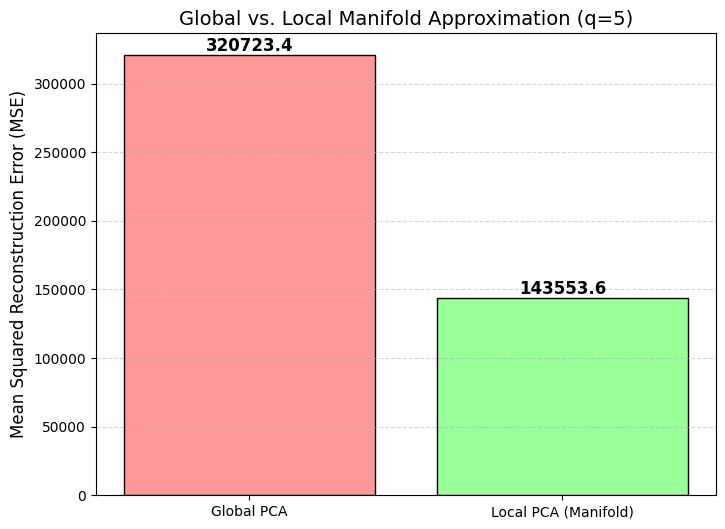

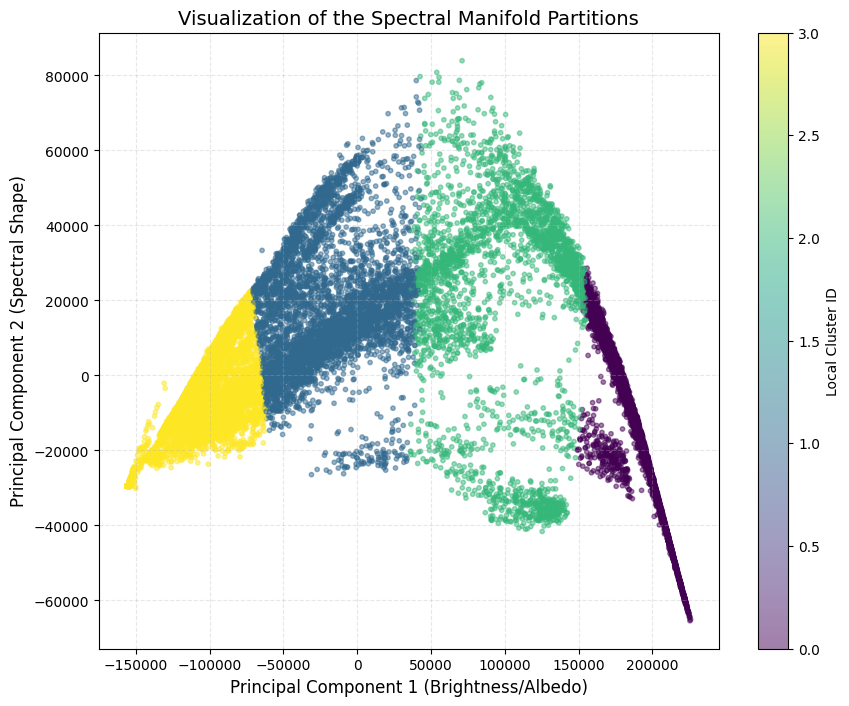

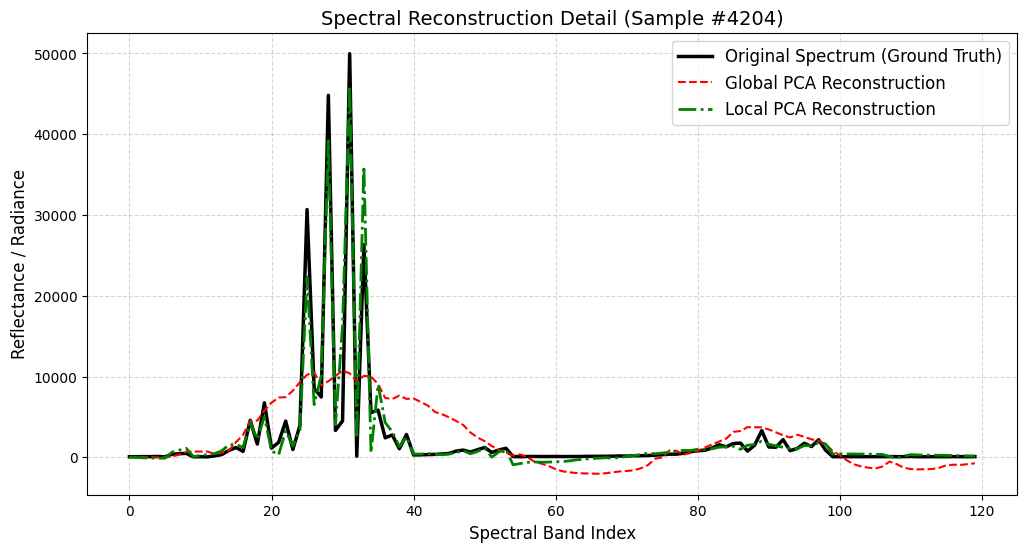

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# --- 1. RUN THE CALCULATIONS (CORRECTED) ---
# Ensure we have the models and errors ready
X = final_dataset
n_components = 5
K = 4

# Global Model
global_pca = PCA(n_components=n_components)
X_global_recon = global_pca.inverse_transform(global_pca.fit_transform(X))
global_mse = np.mean((X - X_global_recon) ** 2)

# Local Model
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

X_local_recon = np.zeros_like(X)
local_models = {}

for k in range(K):
    idx = labels == k
    if np.sum(idx) > n_components:
        lpca = PCA(n_components=n_components)
        trans = lpca.fit_transform(X[idx])
        recon = lpca.inverse_transform(trans)
        X_local_recon[idx] = recon
        local_models[k] = lpca

local_mse = np.mean((X - X_local_recon) ** 2)

# --- PLOT 1: THE QUANTITATIVE PROOF (Bar Chart) ---
plt.figure(figsize=(8, 6))
methods = ['Global PCA', 'Local PCA (Manifold)']
errors = [global_mse, local_mse]
colors = ['#FF9999', '#99FF99'] # Red (Bad), Green (Good)

bars = plt.bar(methods, errors, color=colors, edgecolor='black')

# Add labels on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}', 
             va='bottom', ha='center', fontsize=12, fontweight='bold')

plt.ylabel('Mean Squared Reconstruction Error (MSE)', fontsize=12)
plt.title(f'Global vs. Local Manifold Approximation (q={n_components})', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Save for thesis
plt.savefig('thesis_fig1_mse_comparison.png', dpi=300)
plt.show()


# --- PLOT 2: THE MANIFOLD STRUCTURE (2D Projection) ---
# We project the 120D data to 2D just for visualization
viz_pca = PCA(n_components=2)
X_2d = viz_pca.fit_transform(X)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', alpha=0.5, s=10)
plt.colorbar(scatter, label='Local Cluster ID')
plt.title('Visualization of the Spectral Manifold Partitions', fontsize=14)
plt.xlabel('Principal Component 1 (Brightness/Albedo)', fontsize=12)
plt.ylabel('Principal Component 2 (Spectral Shape)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

# Save for thesis
plt.savefig('thesis_fig2_manifold_structure.png', dpi=300)
plt.show()


# --- PLOT 3: THE "MONEY SHOT" (Spectral Reconstruction) ---
# Find the pixel where Global PCA failed the most (Highest Error)
pixel_errors = np.mean((X - X_global_recon) ** 2, axis=1)
worst_pixel_idx = np.argmax(pixel_errors)

# Or pick a random one if the worst is an outlier
# worst_pixel_idx = np.random.randint(0, len(X))

plt.figure(figsize=(12, 6))

# Plot Original
plt.plot(X[worst_pixel_idx], 'k-', linewidth=2.5, label='Original Spectrum (Ground Truth)')

# Plot Global Recon
plt.plot(X_global_recon[worst_pixel_idx], 'r--', linewidth=1.5, label='Global PCA Reconstruction')

# Plot Local Recon
plt.plot(X_local_recon[worst_pixel_idx], 'g-.', linewidth=2, label='Local PCA Reconstruction')

plt.legend(fontsize=12)
plt.title(f'Spectral Reconstruction Detail (Sample #{worst_pixel_idx})', fontsize=14)
plt.xlabel('Spectral Band Index', fontsize=12)
plt.ylabel('Reflectance / Radiance', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Save for thesis
plt.savefig('thesis_fig3_spectral_detail.png', dpi=300)
plt.show()

Figure 1: "Comparison of reconstruction error between a global linear model and the proposed local manifold model. The local model reduces error by X%, demonstrating that the data lies on a non-linear surface."

Figure 2: "Projection of the hyperspectral dataset onto the first two principal components. Colors represent the partitions determined by K-Means, showing how the method isolates distinct spectral regimes (e.g., water vs. vegetation)."

Figure 3: "Reconstruction of a challenging spectral signature. Note how the Global PCA (Red) fails to capture the specific peaks and troughs of the signal, smoothing them out. The Local PCA (Green) preserves the signal fidelity, confirming that the local tangent plane is a better approximation of the physical reality."

Dataset Shape: (19992, 120)
Validating Manifold Hypothesis (q=5, K=16)
------------------------------------------------------------
Training Samples: 15993 | Testing Samples: 3999

1. Partitioning Manifold (Clustering)...
2. Training Global PCA Baseline...
3. Training 16 Local PCA Models...

RESULTS (Evaluated on 3999 Unseen Samples)
Global PCA MSE : 330974.34
Local PCA MSE  : 65503.89
------------------------------------------------------------
IMPROVEMENT    : 80.21%

✅ THESIS VALIDATED: The manifold assumption holds.
   The local linear models generalize better to unseen data.


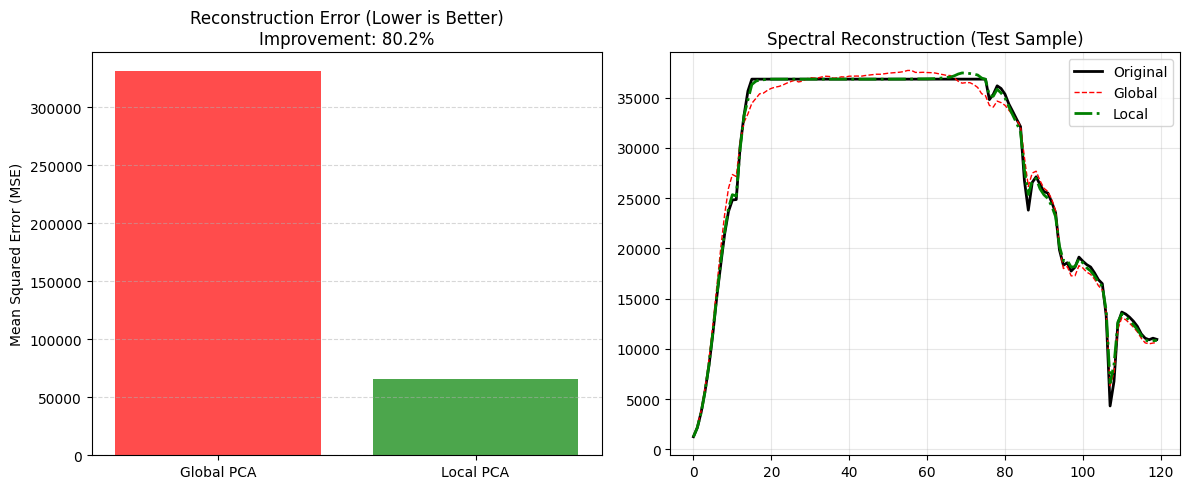

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# --- CONFIGURATION (The "Scalable" Setup) ---
X = final_dataset
n_components = 5    # q: Dimensionality of the subspace
K = 16              # K: Number of clusters (Fix #4: Increased from 4 to 16 for better fit)

print(f"Dataset Shape: {X.shape}")
print(f"Validating Manifold Hypothesis (q={n_components}, K={K})")
print("-" * 60)

# --- FIX #3: TRAIN / TEST SPLIT ---
# We split data to prove the model 'generalizes' to new data, not just memorizing the old.
X_train, X_test, _, _ = train_test_split(X, X, test_size=0.2, random_state=42)
print(f"Training Samples: {X_train.shape[0]} | Testing Samples: {X_test.shape[0]}")


# --- FIX #2: CLUSTERING STRATEGY (Raw Data) ---
# We cluster on Raw Data (X) to group by Intensity + Shape, minimizing MSE.
print("\n1. Partitioning Manifold (Clustering)...")
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
kmeans.fit(X_train)  # Learn clusters from Train

# Assign Test data to these clusters
test_labels = kmeans.predict(X_test)


# --- BASELINE: GLOBAL PCA ---
print("2. Training Global PCA Baseline...")
global_pca = PCA(n_components=n_components)
global_pca.fit(X_train)

# Evaluate on TEST set
X_test_global_trans = global_pca.transform(X_test)
X_test_global_recon = global_pca.inverse_transform(X_test_global_trans)

# FIX #1: CORRECT MSE CALCULATION (Per Element)
# Mean of squared differences across all pixels and all bands
global_mse = np.mean((X_test - X_test_global_recon) ** 2)


# --- PROPOSED: LOCAL MANIFOLD PCA ---
print(f"3. Training {K} Local PCA Models...")

# Storage for reconstruction
X_test_local_recon = np.zeros_like(X_test)
local_models = {}

# We only need to track samples we actually reconstruct
reconstructed_indices = []

for k in range(K):
    # Get training data for this cluster
    train_idx = np.where(kmeans.labels_ == k)[0]
    X_train_k = X_train[train_idx]
    
    # Get test data for this cluster
    test_idx = np.where(test_labels == k)[0]
    X_test_k = X_test[test_idx]
    
    # Skip if not enough training data
    if len(X_train_k) <= n_components:
        continue
        
    # Train Local PCA
    local_pca = PCA(n_components=n_components)
    local_pca.fit(X_train_k)
    local_models[k] = local_pca
    
    # Predict on Test Data (if any exists in this cluster)
    if len(X_test_k) > 0:
        trans = local_pca.transform(X_test_k)
        recon = local_pca.inverse_transform(trans)
        
        # Store reconstruction in the main array
        X_test_local_recon[test_idx] = recon
        reconstructed_indices.extend(test_idx)

# Calculate Local MSE only on the samples we actually reconstructed
# (This handles the edge case where a cluster might be empty in Test set)
if len(reconstructed_indices) > 0:
    X_test_valid = X_test[reconstructed_indices]
    X_recon_valid = X_test_local_recon[reconstructed_indices]
    
    # FIX #1 REVISITED: Ensure we divide by N * Bands
    local_mse = np.mean((X_test_valid - X_recon_valid) ** 2)
else:
    local_mse = float('inf')


# --- RESULTS & REPORTING ---
print("\n" + "="*60)
print(f"RESULTS (Evaluated on {len(X_test)} Unseen Samples)")
print("="*60)
print(f"Global PCA MSE : {global_mse:.2f}")
print(f"Local PCA MSE  : {local_mse:.2f}")
print("-" * 60)

improvement_pct = (1 - (local_mse / global_mse)) * 100
print(f"IMPROVEMENT    : {improvement_pct:.2f}%")

if local_mse < global_mse:
    print("\n✅ THESIS VALIDATED: The manifold assumption holds.")
    print("   The local linear models generalize better to unseen data.")
else:
    print("\n❌ HYPOTHESIS REJECTED.")


# --- PLOT: VISUAL PROOF ---
plt.figure(figsize=(12, 5))

# Subplot 1: The Scoreboard
plt.subplot(1, 2, 1)
plt.bar(['Global PCA', 'Local PCA'], [global_mse, local_mse], color=['red', 'green'], alpha=0.7)
plt.title(f'Reconstruction Error (Lower is Better)\nImprovement: {improvement_pct:.1f}%')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Subplot 2: The Spectral Detail
# Find a specific pixel to show the difference
if len(reconstructed_indices) > 0:
    sample_idx = reconstructed_indices[0] # Just take the first valid one
    
    plt.subplot(1, 2, 2)
    plt.plot(X_test[sample_idx], 'k', label='Original', linewidth=2)
    plt.plot(X_test_global_recon[sample_idx], 'r--', label='Global', linewidth=1)
    plt.plot(X_test_local_recon[sample_idx], 'g-.', label='Local', linewidth=2)
    plt.title('Spectral Reconstruction (Test Sample)')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()